In [270]:
import msgpack

def FromMessagePack(filename):
    with open(filename, "rb") as data_file:
        byte_data = data_file.read()
    data_loaded = msgpack.unpackb(byte_data)
    return data_loaded

In [271]:
import torch
import matplotlib.pyplot as plt

id = 1
filename = f"C:\Projects\MMU\Ifosic\src\Python\Set0{id}.msgpack";
data = FromMessagePack(filename)
traces = torch.tensor(data["Traces"])

start = 0
stop = traces.shape[0] - (traces.shape[0] - 1280)
roi = traces[start:stop,:].transpose(0, 1)
print(roi.shape)
# plt.imshow(roi)
indexes = data["BoundaryIndexes"]
print(indexes)

torch.Size([1950, 1280])
[654, 686, 750, 814, 879, 913]


720
721
722
723
724


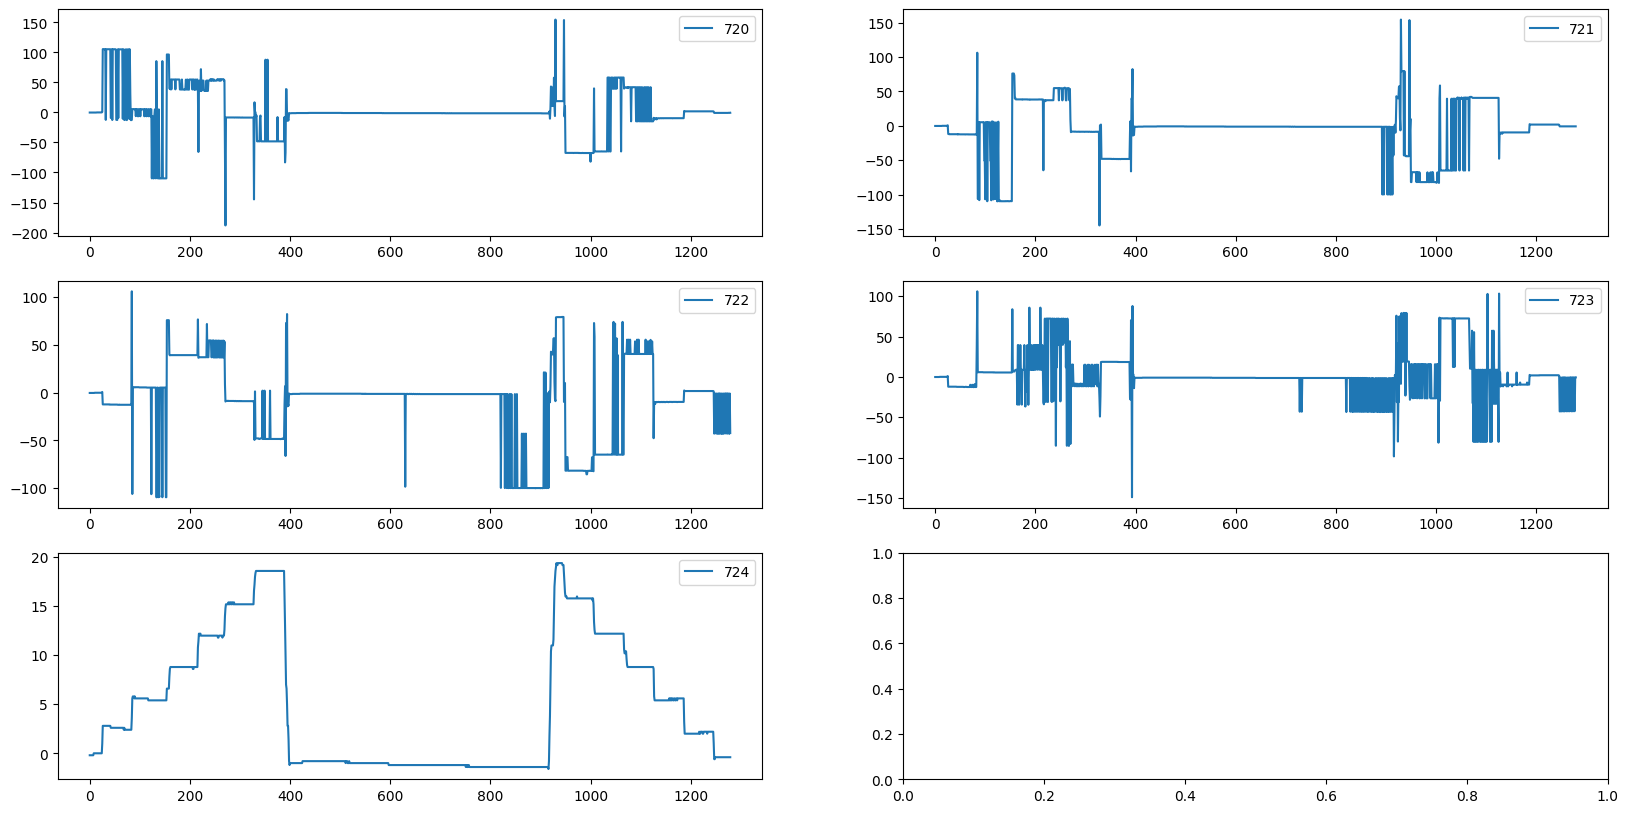

In [274]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean
import math
plt.rcParams["figure.figsize"] = (20,10)

def signal_plot(c: list):
    n = len(c)
    if n == 1:
        plt.plot(roi[c[0]])
    else:
        cols = 2
        rows = math.ceil(n / 2)
        _, ax = plt.subplots(rows, cols)
        i = 0
        for row in range(rows):
            for col in range(cols):
                if i >= n:
                    break
                v = c[i]
                ax[row, col].plot(roi[v])
                ax[row, col].legend([v])
                i += 1
    plt.show()

signal_plot(np.arange(740,750))

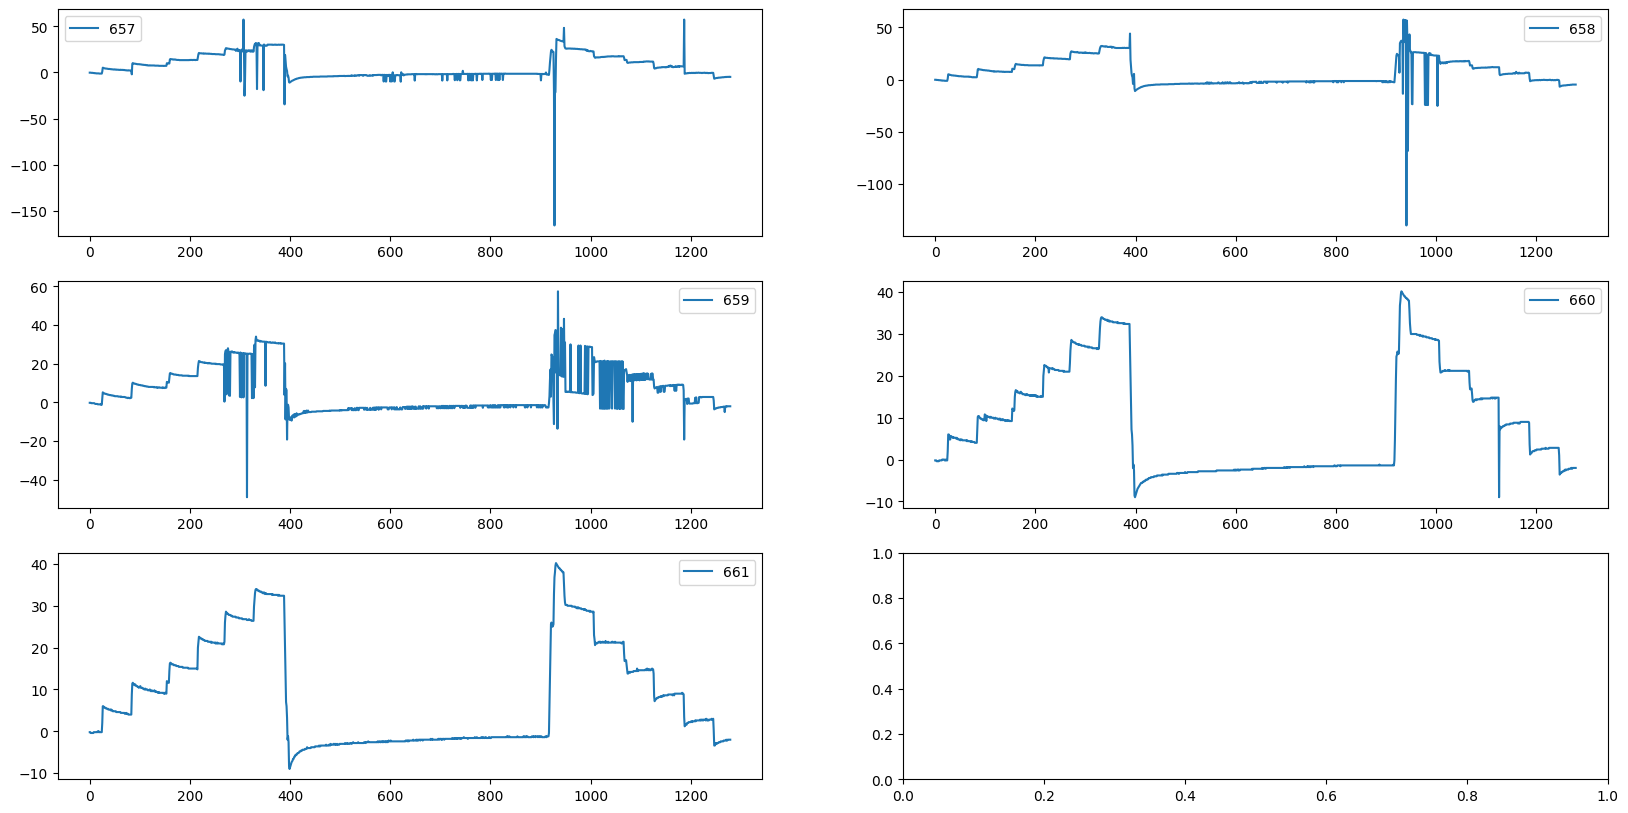

In [222]:
def win(pos = 654, w = 5):
    h = w // 2
    return np.arange(pos-h, pos+h+1)

def data_slider(data: torch.tensor, win = 5):
    h,w = data.shape
    hw = win // 2
    slider = torch.zeros(data.shape[0], win, data.shape[1])
    for i in range(win):
        ss = 0 if i > hw else hw-i
        se = 0 if i < hw else i-hw
        ds = 0 if i < hw else i-hw
        de = 0 if i > hw else hw-i
        # print(ss, se, ds, de)
        slider[ss:h-se,i,:] = data[ds:h-de]

    # slider[2:,0,:] = data[0:-2]
    # slider[1:,1,:] = data[0:-1]
    # slider[:,2,:] = data
    # slider[:data.shape[0]-1,3,:] = data[1:]
    # slider[:data.shape[0]-2,4,:] = data[2:]
    return slider

def signal_plot(data: torch.tensor, idx = 0):
    b,c,w = data.shape
    win = data[idx]
    if c == 1:
        plt.plot(win[0])
    else:
        cols = 2
        rows = math.ceil(c / 2)
        _, ax = plt.subplots(rows, cols)
        i = 0
        for row in range(rows):
            for col in range(cols):
                if i >= c:
                    break
                v = idx-2+i
                ax[row, col].plot(win[i])
                ax[row, col].legend([v])
                i += 1
    plt.show()


sliders = data_slider(roi)
signal_plot(sliders, idx = 659)
# print(roi[:].shape)

[499.3885498046875, 628.111083984375, 384.8537292480469, 762.9971313476562, 876.091064453125, 422.76654052734375, 198.7123565673828, 20.02398681640625, 30.75516128540039, 4.4631829261779785, 47.40885925292969, 18.372806549072266, 8.872428894042969, 21.215089797973633, 20.26622772216797, 13.4447021484375, 64.44377136230469, 8.78635311126709, 44.61614227294922, 15.812653541564941, 25.358234405517578, 24.09730339050293, 12.129303932189941, 39.520626068115234, 53.63170623779297, 242.38812255859375, 796.368896484375, 925.6201782226562, 481.0755310058594, 213.61395263671875, 642.0137329101562, 986.4095458984375, 903.7249145507812, 642.019775390625, 756.8250732421875, 1241.2615966796875, 1137.9306640625, 168.04356384277344, 84.88768768310547, 159.74517822265625, 234.6282196044922, 494.3042297363281, 466.79180908203125, 156.72894287109375, 616.197021484375, 823.8900756835938, 1035.9320068359375, 1492.8734130859375, 1829.272705078125, 913.4891967773438, 140.6106719970703, 79.47981262207031, 154

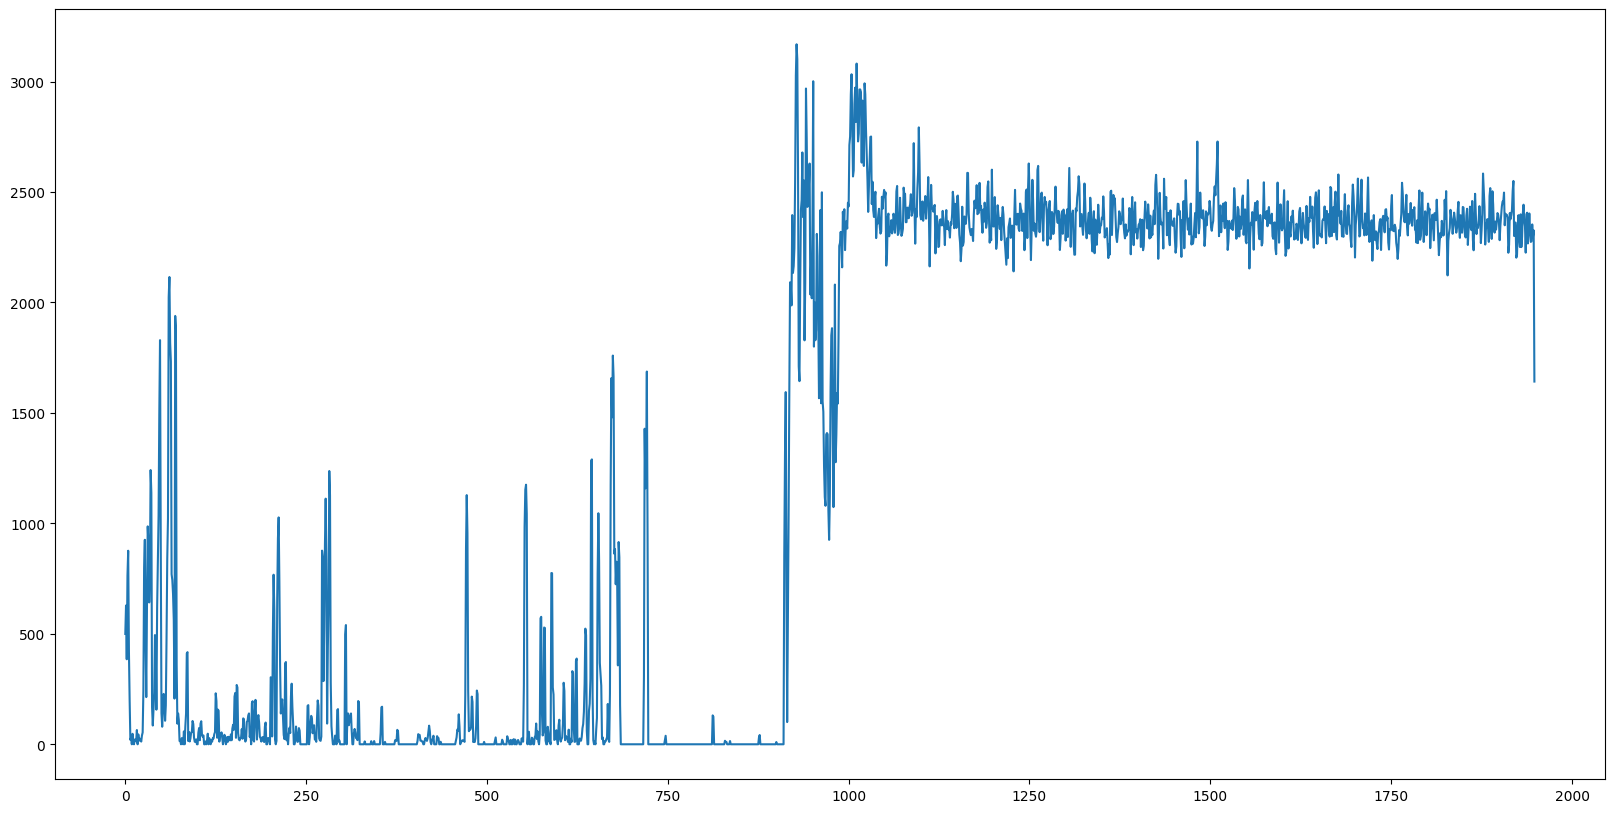

In [213]:
import mplcursors
%matplotlib inline

def show_annotation(sel):
    ind = int(sel.target.index)
    frac = sel.target.index - ind
    x, y = sel.target
    sel.annotation.set_text(f'left index:{ind} frac:{frac:.2f}\nx:{x:.2f} y:{y:.2f}')


inputs, labels = torch.load('dataset_ori.pth')
labels[labels < 0] = 0

d = []
# for i in range(len(indexes)-1):
#     for j in range(indexes[i], indexes[i+1]):
#         d.append(euclidean(inputs[j], inputs[j+1]))
#         #plt.plot(inputs[j].numpy())
for j in range(1,1950):
    d.append(euclidean(inputs[j], inputs[j+1]))

# src = inputs[indexes[0]].numpy()
# dst = inputs[indexes[1]].numpy()
# print(src)
# distance = euclidean(src, dst)
print(d)
# plt.plot(inputs[814].numpy())
# plt.plot(inputs[815].numpy())
# plt.legend([814,815])
d = np.array(d)
d[d<10] = 0
plt.plot(d)
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", show_annotation)
plt.show()



In [259]:
import torch
import torch.nn as nn
from collections import OrderedDict

class SignalNet(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 4, features = 8):
        super(SignalNet, self).__init__()
        # fix input size 1280
        self.feature = nn.Sequential(
            SignalNet._block(in_channels, features, name ="enc1"),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.1),
            SignalNet._block(features, features * 2, name ="enc2"),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.1)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 320, 256),
            nn.Dropout(0.1),
            # target class: noise, signal, transition, leak
            nn.Linear(256, out_channels)
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.fc(x)
        return x
    
    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv1d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm1d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv1d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm1d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

torch.Size([1950, 5, 1280])


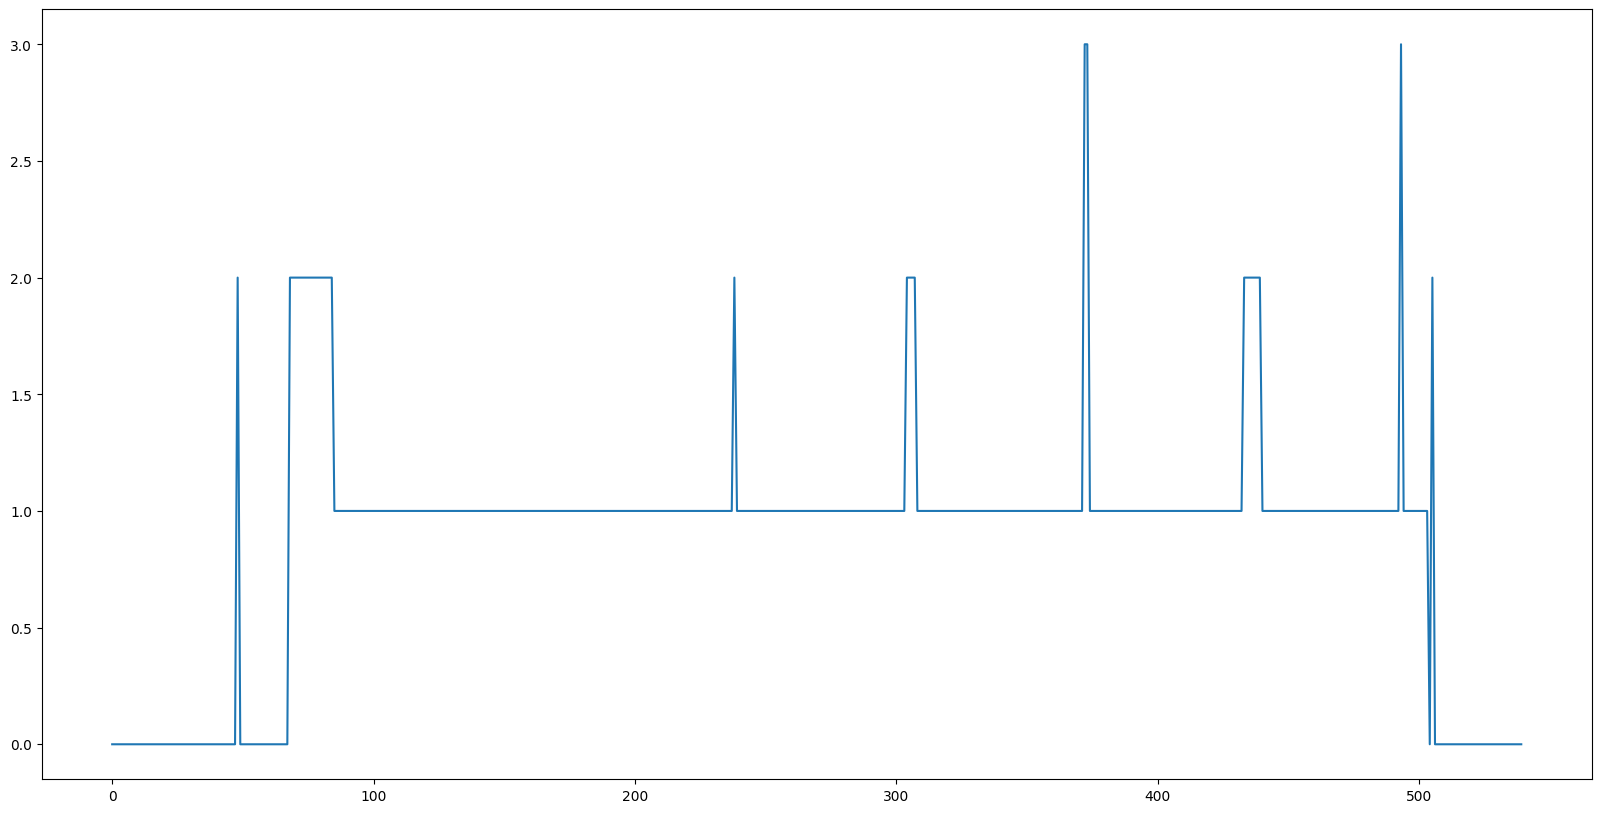

In [261]:
model = SignalNet(in_channels=5)
path = r'C:\\Projects\\MMU\\Ifosic\\src\\Python'
model.load_state_dict(torch.load(f"{path}\\model.pth"))
inputs,labels = torch.load(f"{path}\\dataset.pth")
slice = inputs[1950*2:1950*3]
# x = torch.zeros(roi.shape[0], 1280)
# x[:, :] = roi[:, 840:2120]
# slice = x.unsqueeze(0).permute(1,0,2)
# slice = data_slider(x)
print(slice.shape)
scores = model(slice)
y = torch.argmax(scores, 1)
ty = y[600:1140]
plt.plot(ty)